# Datos atípicos  

¿Qué son los datos atípicos?

¿Hay que eliminarlos?


In [1]:
from google.colab import drive # conexión con drive
drive.mount('/content/drive')
import pandas as pd # Manejo de Data Frame
import numpy as np # Manejo matricial
import warnings # Omitir warnings
warnings.filterwarnings("ignore") # Ignorar warning (me estresan los warnings >:|)
# librerías para Gráficos
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
# Librerías para clustering
from sklearn.cluster import (KMeans, AgglomerativeClustering, DBSCAN)
from scipy.cluster.hierarchy import dendrogram,  linkage # Dendograma
from sklearn.ensemble import IsolationForest
# Score de silueta
from sklearn.metrics import silhouette_score, pairwise_distances_argmin_min
from sklearn.preprocessing import StandardScaler # estandarizar variables.

Mounted at /content/drive


Con la base de datos de las tarjetas de crédito, si seleccionamos una variable como el BALANCE ¿qué observamos?

In [2]:
datos_accidentes = pd.read_csv('/content/drive/MyDrive/Aprendizaje no supervisado/2024-2/Clase 3/total_incidentes_transito.csv',
                 encoding='latin-1')
filtro_atipico= (datos_accidentes["longitud"]==-75.70381587)	& (datos_accidentes["latitud"]==6.22180566	)
datos_accidentes=datos_accidentes[~filtro_atipico]
datos_accidentes = datos_accidentes[datos_accidentes.gravedad!="SOLO DAÑOS"].reset_index(drop=True)
datos_cc = pd.read_csv('/content/drive/MyDrive/Aprendizaje no supervisado/2024-2/Bases de datos/CC GENERAL.csv')
datos_cc = datos_cc.dropna().reset_index(drop=True)
datos_cc.head()

CUST_ID      BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
0  C10001    40.900749           0.818182      95.40              0.00   
1  C10002  3202.467416           0.909091       0.00              0.00   
2  C10003  2495.148862           1.000000     773.17            773.17   
3  C10005   817.714335           1.000000      16.00             16.00   
4  C10006  1809.828751           1.000000    1333.28              0.00   

   INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
0                   95.40      0.000000             0.166667   
1                    0.00   6442.945483             0.000000   
2                    0.00      0.000000             1.000000   
3                    0.00      0.000000             0.083333   
4                 1333.28      0.000000             0.666667   

   ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
0                    0.000000                          0.083333   
1                    0.000000                          0.000000   
2                    1.000000                          0.000000   
3                    0.083333                          0.000000   
4                    0.000000                          0.583333   

   CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT  \
0                    0.00                 0              2        1000.0   
1                    0.25                 4              0        7000.0   
2                    0.00                 0             12        7500.0   
3                    0.00                 0              1        1200.0   
4                    0.00                 0              8        1800.0   

      PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT  TENURE  
0   201.802084        139.509787          0.000000      12  
1  4103.032597       1072.340217          0.222222      12  
2   622.066742        627.284787          0.000000      12  
3   678.334763        244.791237          0.000000      12  
4  1400.057770       2407.246035          0.000000      12

In [3]:
datos_accidentes.gravedad.value_counts()

gravedad
HERIDO    21044
MUERTO      143
Name: count, dtype: int64

Text(0.5, 1.0, 'Histograma de BALANCE')

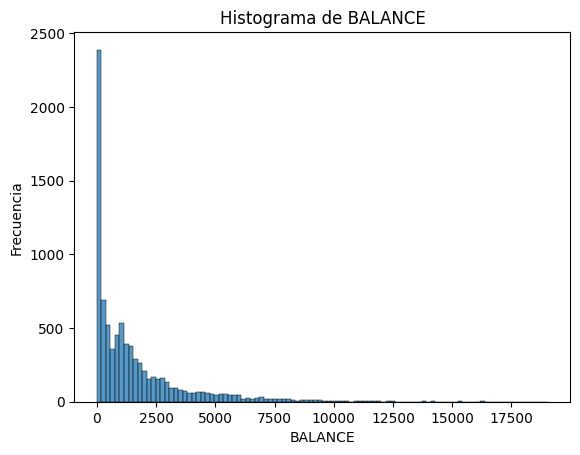

In [4]:
sns.histplot(datos_cc["BALANCE"])
plt.xlabel("BALANCE")
plt.ylabel("Frecuencia")
plt.title("Histograma de BALANCE")

Si observamos la variable BALANCE, se observa lo que llamamos una cola pesada a la derecha. A partir de un balance de 10000 se observan datos muy altos ¿podrían considerarse datos atípicos?

Text(0.5, 1.0, 'Box plot BALANCE')

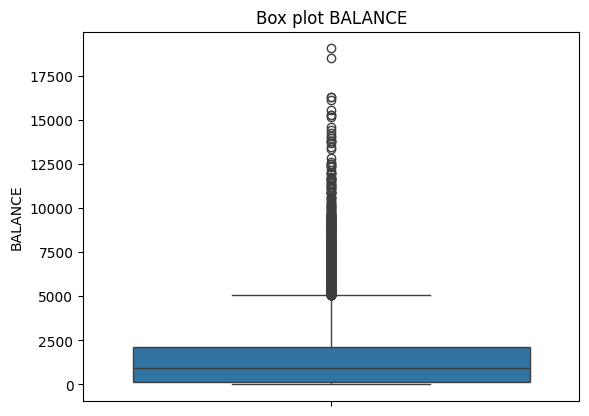

In [5]:
sns.boxplot(datos_cc["BALANCE"])
plt.xlabel("")
plt.ylabel("BALANCE")
plt.title("Box plot BALANCE")

Método de detección de atípicos con box-plot

In [6]:
def outliers_iqr(variable):
  """
  Con esta función obtenemos los valores atípicos con el método de IQR
  """
  Q1 = variable.quantile(0.25) # calculamos el Q1
  Q3 = variable.quantile(0.75) # Calculamos el Q3
  IQR = Q3 - Q1 # Calculamos el rango inter quantil
  # Obtenemos los límites
  lower_bound = Q1 - 1.5 * IQR  # límite inferior
  upper_bound = Q3 + 1.5 * IQR # Límite superior
  outliers = np.where( (variable < lower_bound) | (variable > upper_bound), -1,1 )  # -1 atípico
  return outliers # Retornamos la etiqueta de atípico

def outliers_zscore(variable):
  """
  Con esta función obtenemos los valores atípicos con el método de Z-score
  """
  z_score =StandardScaler().fit_transform(variable.values.reshape(-1, 1))
  outliers = np.where(abs(z_score) > 3, -1,1)
  return outliers

Atipico_IQR_BALANCE
 1    7970
-1     666
Name: count, dtype: int64


<Axes: xlabel='Atipico_IQR_BALANCE', ylabel='BALANCE'>

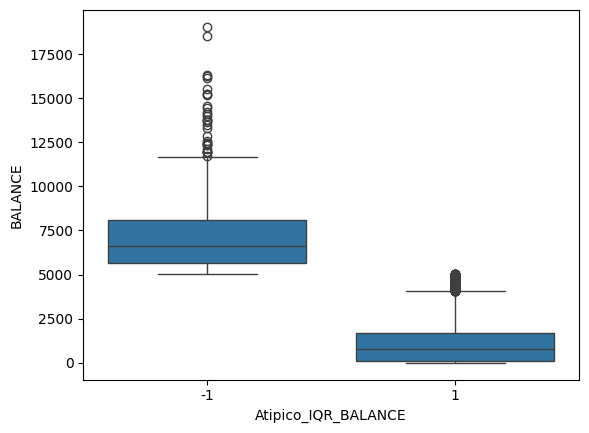

In [7]:
datos_cc["Atipico_IQR_BALANCE"] = outliers_iqr(datos_cc["BALANCE"])
print(datos_cc["Atipico_IQR_BALANCE"].value_counts())
sns.boxplot(datos_cc, y="BALANCE", x= "Atipico_IQR_BALANCE")

Text(0.5, 1.0, 'Histograma de BALANCE')

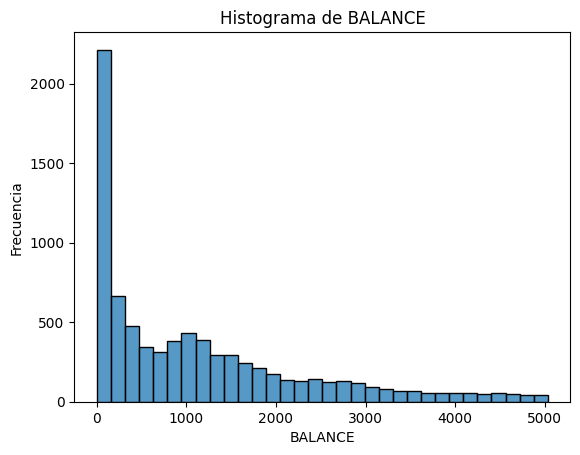

In [8]:
sns.histplot(datos_cc.loc[datos_cc["Atipico_IQR_BALANCE"]==1 ,"BALANCE"])
plt.xlabel("BALANCE")
plt.ylabel("Frecuencia")
plt.title("Histograma de BALANCE")

Atipico_zscore_BALANCE
 1    8450
-1     186
Name: count, dtype: int64


<Axes: xlabel='Atipico_zscore_BALANCE', ylabel='BALANCE'>

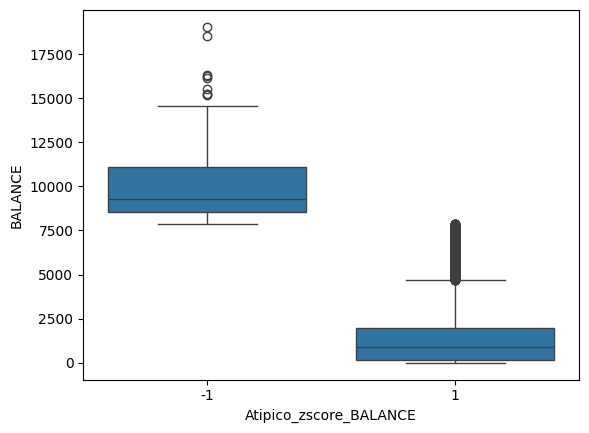

In [9]:
datos_cc["Atipico_zscore_BALANCE"] = outliers_zscore(datos_cc["BALANCE"])
print(datos_cc["Atipico_zscore_BALANCE"].value_counts())
sns.boxplot(datos_cc, y="BALANCE", x= "Atipico_zscore_BALANCE")

In [10]:
datos_accidentes.columns

Index(['OBJECTID', 'Shape', 'radicado', 'fecha', 'hora', 'dia', 'periodo',
       'clase', 'direccion', 'direccion_enc', 'cbml', 'tipo_geocod',
       'gravedad', 'barrio', 'comuna', 'diseno', 'dia_nombre', 'mes',
       'mes_nombre', 'x_magnamed', 'y_magnamed', 'longitud', 'latitud'],
      dtype='object')

In [11]:
sum(outliers_iqr(datos_accidentes["longitud"])==-1)

464

In [12]:
sum(outliers_iqr(datos_accidentes["latitud"])==-1)

117

In [13]:
sum(outliers_zscore(datos_accidentes["longitud"])==-1)

array([245])

In [14]:
sum(outliers_zscore(datos_accidentes["latitud"])==-1)

array([11])

In [15]:
datos_accidentes["Atipico_IQR_ubicacion"] = np.where((outliers_iqr(datos_accidentes["longitud"])==-1) |
                                             (outliers_iqr(datos_accidentes["latitud"])==-1), -1,1 )


fig = px.scatter(datos_accidentes, x="longitud", y="latitud", color="Atipico_IQR_ubicacion",marginal_x="box", marginal_y="box")
fig.show()

In [16]:
datos_accidentes["Atipico_zscore_ubicacion"] = np.where((outliers_zscore(datos_accidentes["longitud"])==-1) |
                                             (outliers_zscore(datos_accidentes["latitud"])==-1), -1,1 )


fig = px.scatter(datos_accidentes, x="longitud", y="latitud", color="Atipico_zscore_ubicacion",marginal_x="box", marginal_y="box")
fig.show()

In [17]:
def outliers_iqr_distancia(variable):
  """
  Con esta función obtenemos los valores atípicos con el método de IQR
  """
  Q1 = variable.quantile(0.25) # calculamos el Q1
  Q3 = variable.quantile(0.75) # Calculamos el Q3
  IQR = Q3 - Q1 # Calculamos el rango inter quantil
  # Obtenemos los límites
  lower_bound = Q1 - 1.5 * IQR  # límite inferior
  upper_bound = Q3 + 1.5 * IQR # Límite superior
  outliers = np.where( (variable > upper_bound), -1,1 )  # -1 atípico
  return outliers # Retornamos la etiqueta de atípico

def outliers_zscore_distancia(variable):
  """
  Con esta función obtenemos los valores atípicos con el método de Z-score
  """
  z_score =StandardScaler().fit_transform(variable.values.reshape(-1, 1))
  outliers = np.where(z_score > 3, -1,1)
  return outliers

Text(0.5, 1.0, 'Histograma de distancia_centro')

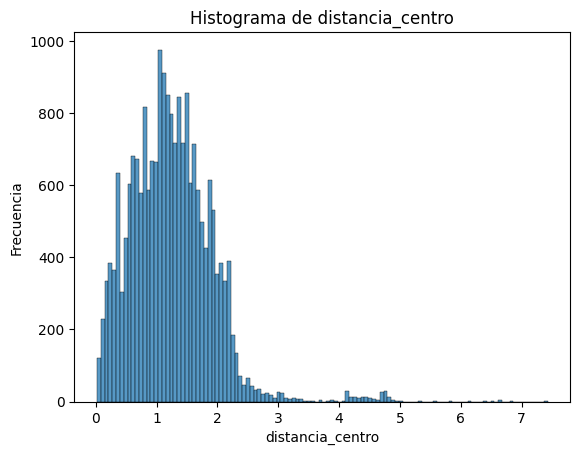

In [18]:
feature_scale = StandardScaler().fit_transform(datos_accidentes[["longitud", "latitud"]])
feature_scale
datos_accidentes["distancia_centro"] =np.sqrt((feature_scale**2).sum(1))
sns.histplot(datos_accidentes["distancia_centro"])
plt.xlabel("distancia_centro")
plt.ylabel("Frecuencia")
plt.title("Histograma de distancia_centro")

Text(0.5, 1.0, 'Histograma de distancia_centro')

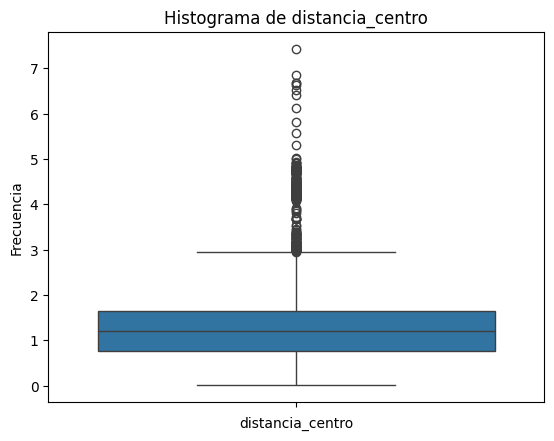

In [19]:
sns.boxplot(datos_accidentes["distancia_centro"])
plt.xlabel("distancia_centro")
plt.ylabel("Frecuencia")
plt.title("Histograma de distancia_centro")

In [20]:
feature_scale = StandardScaler().fit_transform(datos_accidentes[["longitud", "latitud"]])
feature_scale
datos_accidentes["distancia_centro"] =np.sqrt((feature_scale**2).sum(1))
datos_accidentes["Atipico_IQR_distancia_centro"] = outliers_iqr_distancia(datos_accidentes["distancia_centro"])
print(datos_accidentes["Atipico_IQR_distancia_centro"].value_counts())
datos_accidentes["Atipico_zscore_distancia_centro"] = outliers_zscore_distancia(datos_accidentes["distancia_centro"])
print(datos_accidentes["Atipico_zscore_distancia_centro"].value_counts())

Atipico_IQR_distancia_centro
 1    20883
-1      304
Name: count, dtype: int64
Atipico_zscore_distancia_centro
 1    20960
-1      227
Name: count, dtype: int64


In [21]:
fig = px.scatter(datos_accidentes, x="longitud", y="latitud", color="Atipico_IQR_distancia_centro",marginal_x="box", marginal_y="box")
fig.show()

In [22]:
fig = px.scatter(datos_accidentes, x="longitud", y="latitud", color="Atipico_zscore_distancia_centro",marginal_x="box", marginal_y="box")
fig.show()

Text(0.5, 1.0, 'Histograma de distancia_centro')

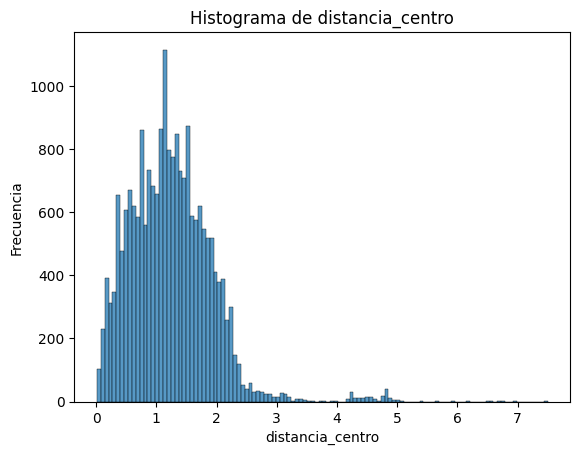

In [23]:
feature_scale = pd.DataFrame(StandardScaler(with_mean=False).fit_transform(datos_accidentes[["longitud", "latitud"]]))
feature_scale=feature_scale-feature_scale.median(axis=0)
datos_accidentes["distancia_centro"] =np.sqrt((feature_scale**2).sum(1))
sns.histplot(datos_accidentes["distancia_centro"])
plt.xlabel("distancia_centro")
plt.ylabel("Frecuencia")
plt.title("Histograma de distancia_centro")

In [24]:
datos_accidentes["Atipico_zscore_distancia_centro"] = outliers_zscore_distancia(datos_accidentes["distancia_centro"])
print(datos_accidentes["Atipico_zscore_distancia_centro"].value_counts())

fig = px.scatter(datos_accidentes, x="longitud", y="latitud", color="Atipico_zscore_distancia_centro",marginal_x="box", marginal_y="box")
fig.show()

Atipico_zscore_distancia_centro
 1    20952
-1      235
Name: count, dtype: int64


In [25]:
fig = px.scatter_3d(datos_cc, x="BALANCE", y='PURCHASES', z="CREDIT_LIMIT", size_max=0.1)
fig.update_traces(marker=dict(size=1))
centro_cc= pd.DataFrame(datos_cc[["BALANCE","PURCHASES", "CREDIT_LIMIT" ]].median()).T
centro_cc.loc[1,:] = datos_cc.loc[datos_cc["BALANCE"]==datos_cc["BALANCE"].max(),["BALANCE","PURCHASES", "CREDIT_LIMIT" ]].values
linea = px.line_3d(centro_cc,x="BALANCE", y='PURCHASES', z="CREDIT_LIMIT")
linea.data[0].line.color = 'red'
fig.add_trace(linea.data[0])

# Mostrar el gráfico
fig.show()


# Distancia tarjetas de crédito


Text(0.5, 1.0, 'Histograma de distancia_centro')

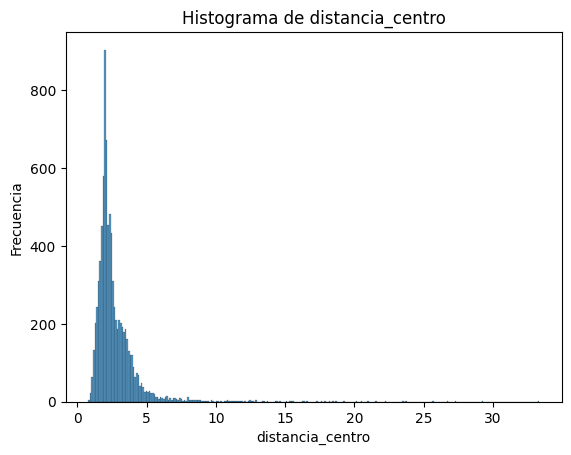

In [56]:
variables_cc=['BALANCE',	'BALANCE_FREQUENCY',	'PURCHASES',	'INSTALLMENTS_PURCHASES',
              'PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY','CREDIT_LIMIT',
              'PAYMENTS',	'MINIMUM_PAYMENTS',	'PRC_FULL_PAYMENT']

feature_scale =StandardScaler().fit_transform(datos_cc[variables_cc])
datos_cc["distancia_centro"]= np.sqrt((feature_scale**2).sum(1))
sns.histplot(datos_cc["distancia_centro"])
plt.xlabel("distancia_centro")
plt.ylabel("Frecuencia")
plt.title("Histograma de distancia_centro")

Text(0.5, 1.0, 'Histograma de distancia_centro')

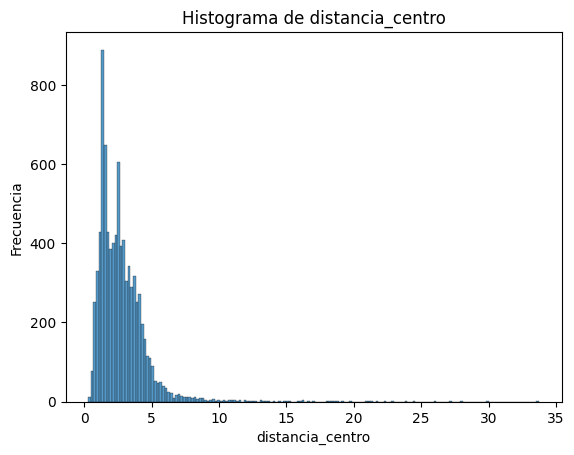

In [57]:
feature_scale =pd.DataFrame(StandardScaler(with_mean=False).fit_transform(datos_cc[variables_cc]))
feature_scale=feature_scale-feature_scale.median(axis=0)
datos_cc["distancia_centro_media"]= np.sqrt((feature_scale**2).sum(1))
sns.histplot(datos_cc["distancia_centro_media"])
plt.xlabel("distancia_centro")
plt.ylabel("Frecuencia")
plt.title("Histograma de distancia_centro")

In [58]:
datos_cc["atipico_iqr_distancia_centro"] = outliers_iqr_distancia(datos_cc["distancia_centro"])
print(datos_cc["atipico_iqr_distancia_centro"].value_counts())
datos_cc["atipico_zcore_distancia_centro"] = outliers_zscore_distancia(datos_cc["distancia_centro"])
print(datos_cc["atipico_zcore_distancia_centro"].value_counts())
datos_cc["atipico_iqr_distancia_centro_mediana"] = outliers_iqr_distancia(datos_cc["distancia_centro_media"])
print(datos_cc["atipico_iqr_distancia_centro_mediana"].value_counts())
datos_cc["atipico_zcore_distancia_centro_mediana"] = outliers_zscore_distancia(datos_cc["distancia_centro_media"])
print(datos_cc["atipico_zcore_distancia_centro_mediana"].value_counts())

atipico_iqr_distancia_centro
 1    8208
-1     428
Name: count, dtype: int64
atipico_zcore_distancia_centro
 1    8511
-1     125
Name: count, dtype: int64
atipico_iqr_distancia_centro_mediana
 1    8396
-1     240
Name: count, dtype: int64
atipico_zcore_distancia_centro_mediana
 1    8523
-1     113
Name: count, dtype: int64


# Isolatison forest

In [58]:
modelo_atipicos = IsolationForest()
modelo_atipicos.fit(datos_accidentes[["longitud","latitud"]])
datos_accidentes["atipico_isolation_forest"] = modelo_atipicos.predict(datos_accidentes[["longitud","latitud"]])
datos_accidentes["atipico_isolation_forest"].value_counts()


In [59]:
fig = px.scatter(datos_accidentes, x="longitud", y="latitud", color="atipico_isolation_forest",marginal_x="box", marginal_y="box")
fig.show()

In [60]:
modelo_atipicos = IsolationForest(contamination= 0.01, random_state=123)
modelo_atipicos.fit(datos_accidentes[["longitud","latitud"]])
datos_accidentes["atipico_isolation_forest"] = modelo_atipicos.predict(datos_accidentes[["longitud","latitud"]])
datos_accidentes["atipico_isolation_forest"].value_counts()


atipico_isolation_forest
 1    20976
-1      211
Name: count, dtype: int64

In [61]:
fig = px.scatter(datos_accidentes, x="longitud", y="latitud", color="atipico_isolation_forest"                 )
fig.show()

In [63]:
modelo_atipicos = IsolationForest(contamination=0.01)
modelo_atipicos.fit(datos_cc[variables_cc])
datos_cc["atipico_isolation_forest"] = modelo_atipicos.predict(datos_cc[variables_cc])
datos_cc["atipico_isolation_forest"].value_counts()

atipico_isolation_forest
 1    8549
-1      87
Name: count, dtype: int64

# Implementación de clúster

Para la implementación de segmentación es importante realizar una estandarización de variables.

In [64]:
scaler = StandardScaler()
scaled_features= pd.DataFrame(scaler.fit_transform(datos_cc[variables_cc]))

# Implementación de K-means

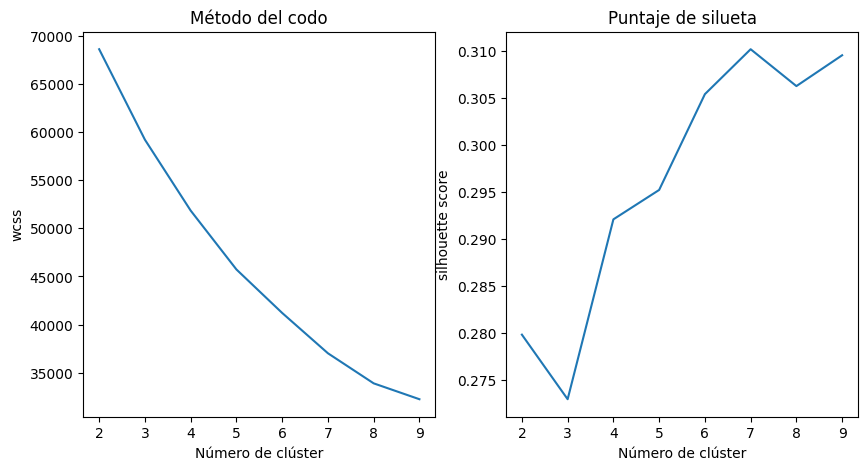

In [65]:
silueta_score=[] # puntaje de silueta
wcss =[] #
n_clusters= range( 2,10)
for k in n_clusters:
  k_means=KMeans(k, random_state=123)
  k_means.fit(scaled_features)
  wcss.append(k_means.inertia_ )
  silueta = silhouette_score(scaled_features, k_means.labels_)
  silueta_score.append(silueta)
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].plot(n_clusters,wcss)
axs[0].set_title("Método del codo")
axs[0].set_xlabel("Número de clúster" )
axs[0].set_ylabel("wcss" )
axs[1].plot( n_clusters,silueta_score)
axs[1].set_title("Puntaje de silueta")
axs[1].set_xlabel("Número de clúster" )
axs[1].set_ylabel("silhouette score" )
plt.show()

In [66]:
k_means=KMeans(7, random_state=123)
k_means.fit(scaled_features )
pd.Series(k_means.labels_).value_counts()

3    3228
5    2231
0    1122
6    1057
2     862
1      99
4      37
Name: count, dtype: int64

In [67]:
scaled_features_drop= StandardScaler().fit_transform(datos_cc.loc[datos_cc["atipico_isolation_forest"]==1, variables_cc])

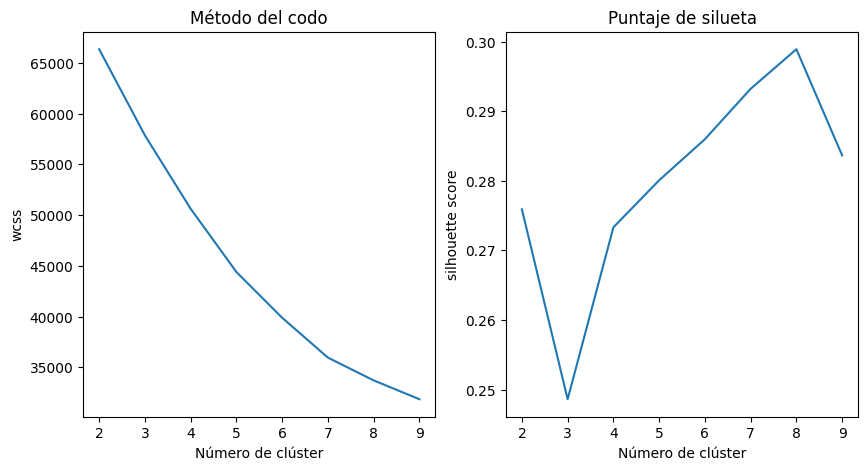

In [68]:
silueta_score=[] # puntaje de silueta
wcss =[] #
# scaled_features_drop =  scaled_features[datos_cc["atipico_isolation_forest"]==1]

n_clusters= range( 2,10)
for k in n_clusters:
  k_means=KMeans(k, random_state=123)
  k_means.fit(scaled_features_drop)
  wcss.append(k_means.inertia_ )
  silueta = silhouette_score(scaled_features_drop, k_means.labels_)
  silueta_score.append(silueta)
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].plot(n_clusters,wcss)
axs[0].set_title("Método del codo")
axs[0].set_xlabel("Número de clúster" )
axs[0].set_ylabel("wcss" )
axs[1].plot( n_clusters,silueta_score)
axs[1].set_title("Puntaje de silueta")
axs[1].set_xlabel("Número de clúster" )
axs[1].set_ylabel("silhouette score" )
plt.show()

In [69]:
k_means=KMeans(8, random_state=123)
k_means.fit(scaled_features_drop )
pd.Series(k_means.labels_).value_counts()

6    2962
0    2009
2    1056
5     960
3     766
1     511
7     237
4      48
Name: count, dtype: int64

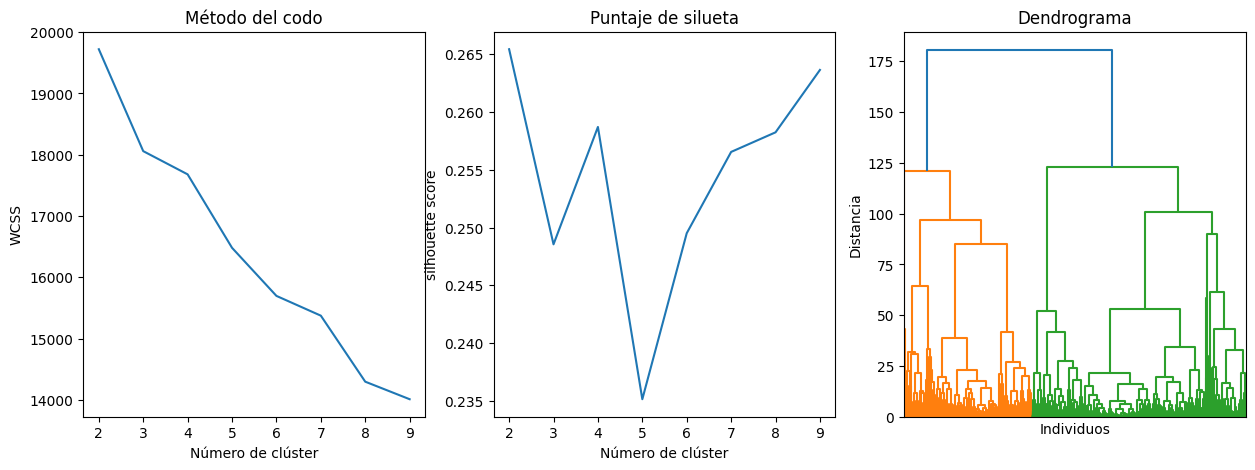

In [73]:
silueta =[]
wcss =[]


n_cluster=range(2,10)
for i in n_cluster:
  jerarquico = AgglomerativeClustering(i)
  jerarquico.fit(scaled_features)
  scaled_temp= pd.DataFrame(scaled_features)
  scaled_temp["labels"]=jerarquico.labels_
  centros= scaled_temp.groupby("labels").mean()  # obteniendo centros
  argmin, distance =pairwise_distances_argmin_min(scaled_features,centros  )  # obteniendo distancias
  wcss.append(np.sum(distance) )
  score = silhouette_score(scaled_features,jerarquico.labels_ )
  silueta.append(score)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].plot( (n_cluster), wcss  )
axes[0].set_ylabel("WCSS")
axes[0].set_title("Método del codo")
axes[0].set_xlabel("Número de clúster" )
axes[1].plot( (n_cluster), silueta  )
axes[1].set_ylabel("silhouette score")
axes[1].set_title("Puntaje de silueta")
axes[1].set_xlabel("Número de clúster" )
# visualización clustering jerarquico
dist_matrix = linkage(scaled_features, method='ward')
# Visualizar el dendrograma
dendrogram(dist_matrix,no_labels=True)
axes[2].set_title('Dendrograma')
axes[2].set_xlabel('Individuos')
axes[2].set_ylabel('Distancia')
plt.show()

In [75]:
scaled_features_drop= StandardScaler().fit_transform(datos_cc.loc[datos_cc["atipico_isolation_forest"]==1, variables_cc])

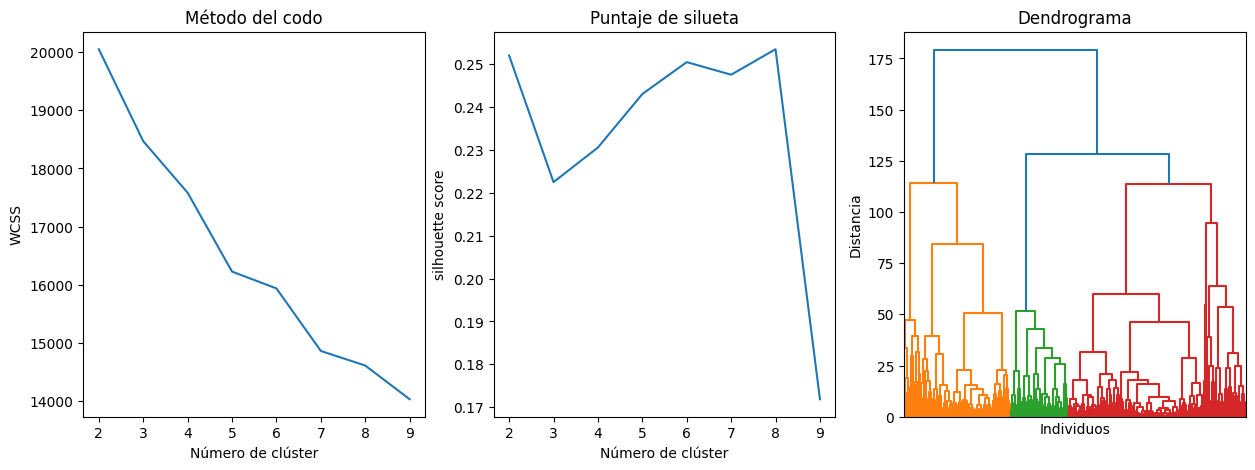

In [76]:
silueta =[]
wcss =[]
# scaled_features_drop =  scaled_features[datos_cc["atipico_zcore_distancia_centro_mediana"]==1]

n_cluster=range(2,10)
for i in n_cluster:
  jerarquico = AgglomerativeClustering(i)
  jerarquico.fit(scaled_features_drop)
  scaled_temp= pd.DataFrame(scaled_features_drop)
  scaled_temp["labels"]=jerarquico.labels_
  centros= scaled_temp.groupby("labels").mean()  # obteniendo centros
  argmin, distance =pairwise_distances_argmin_min(scaled_features,centros  )  # obteniendo distancias
  wcss.append(np.sum(distance) )
  score = silhouette_score(scaled_features_drop,jerarquico.labels_ )
  silueta.append(score)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].plot( (n_cluster), wcss  )
axes[0].set_ylabel("WCSS")
axes[0].set_title("Método del codo")
axes[0].set_xlabel("Número de clúster" )
axes[1].plot( (n_cluster), silueta  )
axes[1].set_ylabel("silhouette score")
axes[1].set_title("Puntaje de silueta")
axes[1].set_xlabel("Número de clúster" )
# visualización clustering jerarquico
dist_matrix = linkage(scaled_features_drop, method='ward')
# Visualizar el dendrograma
dendrogram(dist_matrix,no_labels=True)
axes[2].set_title('Dendrograma')
axes[2].set_xlabel('Individuos')
axes[2].set_ylabel('Distancia')
plt.show()

# DB-SCAN

In [77]:
accidentes_scale =StandardScaler().fit_transform( datos_accidentes[["longitud", "latitud"]])
db_scan = DBSCAN(eps=0.9, min_samples=10 )
db_scan.fit(accidentes_scale)
datos_accidentes["labels_db_scan"] = db_scan.labels_.astype(str)
datos_accidentes["labels_db_scan"].value_counts()
fig = px.scatter(datos_accidentes, x="longitud", y="latitud", color="labels_db_scan")
fig.show()

In [191]:
cc_scale =pd.DataFrame(StandardScaler().fit_transform( datos_cc[ variables_cc ]))

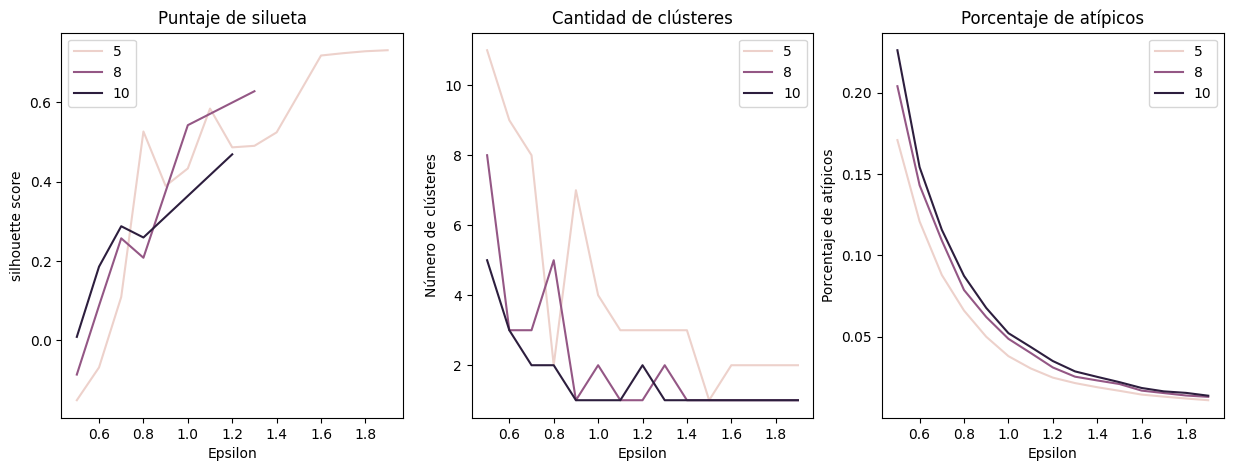

In [207]:
silueta =[]
num_clusteres=[]
eps_=[]
atipicos= []
min_points=[]
min_puntos=[5,8,10]

epsilon= np.arange(0.5,2,0.1)
for i in epsilon:
  for j in min_puntos:
    eps_.append(i)
    min_points.append(j)
    db_scan = DBSCAN(eps=i, min_samples=j)
    db_scan.fit(cc_scale)
    scaled_temp= pd.DataFrame(cc_scale)
    scaled_temp["labels"]=db_scan.labels_
    filtro= scaled_temp["labels"]!=-1
    num_ =scaled_temp.loc[filtro,"labels"].nunique()
    num_clusteres.append(num_)
    atipicos.append( (1-filtro.mean()) )
    if  num_>1:
      score = silhouette_score(cc_scale,scaled_temp["labels"] )
      silueta.append(score)
    else:
      silueta.append(np.nan)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
sns.lineplot(x=eps_, y=silueta, hue=min_points, ax=axes[0])
axes[0].set_ylabel("silhouette score")
axes[0].set_title("Puntaje de silueta")
axes[0].set_xlabel("Epsilon" )
sns.lineplot(x=eps_, y=num_clusteres, hue=min_points, ax=axes[1])
axes[1].set_title('Cantidad de clústeres')
axes[1].set_xlabel('Epsilon')
axes[1].set_ylabel('Número de clústeres')
sns.lineplot(x=eps_, y=atipicos, hue=min_points, ax=axes[2])
axes[2].set_title('Porcentaje de atípicos')
axes[2].set_xlabel('Epsilon')
axes[2].set_ylabel('Porcentaje de atípicos')
plt.show()

In [208]:
pd.DataFrame( {"epsilon": eps_,"min_points":min_points,"Atípicos":atipicos, "silueta":silueta,"Clústeres":num_clusteres } )

epsilon  min_points  Atípicos   silueta  Clústeres
0       0.5           5  0.170797 -0.150452         11
1       0.5           8  0.203914 -0.085873          8
2       0.5          10  0.226031  0.009025          5
3       0.6           5  0.120774 -0.067906          9
4       0.6           8  0.143006  0.087652          3
5       0.6          10  0.154122  0.185797          3
6       0.7           5  0.087888  0.109444          8
7       0.7           8  0.109078  0.257145          3
8       0.7          10  0.115679  0.287568          2
9       0.8           5  0.066003  0.526074          2
10      0.8           8  0.078624  0.208228          5
11      0.8          10  0.087309  0.259227          2
12      0.9           5  0.049907  0.389151          7
13      0.9           8  0.062066       NaN          1
14      0.9          10  0.067624       NaN          1
15      1.0           5  0.037981  0.433101          4
16      1.0           8  0.048634  0.542022          2
17      1.0          10  0.052107       NaN          1
18      1.1           5  0.030454  0.583749          3
19      1.1           8  0.039949       NaN          1
20      1.1          10  0.043654       NaN          1
21      1.2           5  0.024780  0.486163          3
22      1.2           8  0.031033       NaN          1
23      1.2          10  0.034970  0.468586          2
24      1.3           5  0.021422  0.490028          3
25      1.3           8  0.025359  0.627458          2
26      1.3          10  0.028601       NaN          1
27      1.4           5  0.018874  0.523920          3
28      1.4           8  0.023043       NaN          1
29      1.4          10  0.025243       NaN          1
30      1.5           5  0.016674       NaN          1
31      1.5           8  0.020843       NaN          1
32      1.5          10  0.022001       NaN          1
33      1.6           5  0.014358  0.717395          2
34      1.6           8  0.016790       NaN          1
35      1.6          10  0.018411       NaN          1
36      1.7           5  0.013085  0.723255          2
37      1.7           8  0.015285       NaN          1
38      1.7          10  0.016327       NaN          1
39      1.8           5  0.011927  0.728142          2
40      1.8           8  0.013780       NaN          1
41      1.8          10  0.015401       NaN          1
42      1.9           5  0.010885  0.730708          2
43      1.9           8  0.012969       NaN          1
44      1.9          10  0.013664       NaN          1

In [213]:
db_scan = DBSCAN(eps=1,min_samples=8)
db_scan.fit(cc_scale)
datos_cc["labels"]=db_scan.labels_

In [214]:
datos_cc["labels"].value_counts()

labels
 0    8208
-1     420
 1       8
Name: count, dtype: int64